# PaddlePaddle Image Classification with OpenVINO

This demo shows how to run MobileNetV3 Large PaddePaddle model on OpenVINO natively. Instead of exportingthe PaddlePaddle model to ONNX, and then create the Intermediate Representation (IR) format through OpenVINO optimizer, we can now read direct from the pdmodel without any conversions.

In [ ]:
import os
import sys
import numpy as np
import json
import cv2

from openvino.inference_engine import IENetwork, IECore, ExecutableNetwork
from IPython.display import Image

def image_preprocess_mobilenetv3(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    img = np.transpose(img, [2,0,1]) / 255
    img = np.expand_dims(img, 0)

    img_mean = np.array([0.485, 0.456,0.406]).reshape((3,1,1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3,1,1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)

def top_k(result, topk=5):
    indices = np.argsort(-result[0])
    imagenet_classes = json.loads(open("utils/imagenet_class_index.json").read())
    #print(imagenet_classes)
    # TopK
    for i in range(topk):
        print("Class name:","'"+imagenet_classes[str(indices[0][i])][1]+"'", 
              ", classid:", indices[0][i],", probability:", result[0][0][indices[0][i]])


Download paddle infernce model from PaddleHub. It may take a while for the first time to download it.

In [ ]:
!pip install --upgrade paddlepaddle==2.1 -i https://mirror.baidu.com/pypi/simple
!pip install --upgrade paddlehub -i https://mirror.baidu.com/pypi/simple

In [ ]:
!pip uninstall paddlepaddle

In [18]:
import paddlehub as hub

MODEL_NAME = "mobilenet_v3_large_imagenet_ssld"
hub.config.server = "https://paddlepaddle.org.cn/paddlehub"

model = hub.Module(name=MODEL_NAME)
model.save_inference_model(dirname="models/mobilenetv3", model_filename="inference.pdmodel", params_filename="inference.pdparams")

[2021-08-18 12:20:35,007] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


Class name: 'Labrador_retriever' , classid: 208 , probability: 8.733168
Class name: 'schipperke' , classid: 223 , probability: 8.643775
Class name: 'Staffordshire_bullterrier' , classid: 179 , probability: 8.246495
Class name: 'flat-coated_retriever' , classid: 205 , probability: 7.7925816
Class name: 'groenendael' , classid: 224 , probability: 7.359795


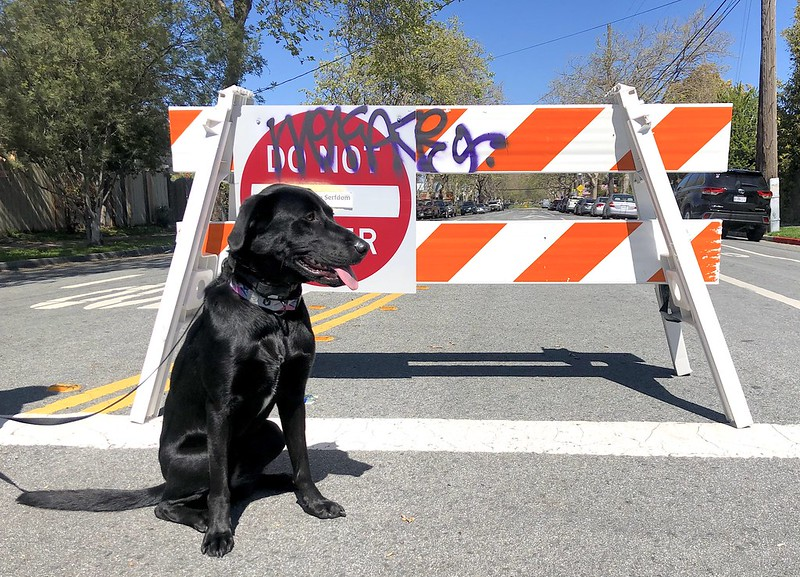

In [14]:
ie = IECore()
net = ie.read_network("models/mobilenetv3/inference.pdmodel","models/mobilenetv3/inference.pdparams")
#MobileNetV3_large_x1_0

filename = "coco.jpg"
test_image = image_preprocess_mobilenetv3(filename) 

# pdmodel might be dynamic shape, this will reshape based on the input
input_key = list(net.input_info.items())[0][0] # 'inputs'
net.reshape({input_key: test_image.shape})

#load the network on CPU
exec_net = ie.load_network(net, 'CPU') 
assert isinstance(exec_net, ExecutableNetwork)

#perform the inference step
output = exec_net.infer({input_key: test_image})
result_ie = list(output.values())

#filter and print the top 5 results 
top_k(result_ie)
Image(filename=filename) 